In [3]:
import torch
import torch.nn as nn
import math

In [4]:
class InputEmbeddings(nn.Module):
  def __init__(self ,d_model: int, vocab_size: int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * math.sqrt(self.d_model)

In [5]:
vocab_size = 5  # Number of unique words in the sentence
embedding_dim = 512  # Embedding vector size

embedding_layer = nn.Embedding(vocab_size, embedding_dim)
input_indices = torch.tensor([0, 1, 2, 3, 0, 4])
output_embeddings = embedding_layer(input_indices)

print("Input indices:", input_indices)
print("Output embeddings:\n", output_embeddings)

Input indices: tensor([0, 1, 2, 3, 0, 4])
Output embeddings:
 tensor([[ 1.5966,  0.7098,  0.5696,  ..., -0.3408, -1.2050, -1.2534],
        [-0.6932, -1.3424, -0.6425,  ..., -0.3792, -2.4714, -0.2685],
        [-1.6871,  0.8194, -0.1792,  ..., -0.8387,  1.4397, -0.4078],
        [-1.4146, -0.0620,  0.6800,  ..., -1.4584, -0.5900, -1.1313],
        [ 1.5966,  0.7098,  0.5696,  ..., -0.3408, -1.2050, -1.2534],
        [ 1.4449,  0.5153,  2.7349,  ...,  0.0307,  1.9482,  0.0201]],
       grad_fn=<EmbeddingBackward0>)


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
      super().__init__()
      self.d_model = d_model
      self.seq_len = seq_len
      self.dropout = nn.Dropout(dropout)

      pe = torch.zeros(seq_len, d_model)
      # pe.shape = (seq_len, d_model)

      position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
      # print(position.shape) # (seq_len, 1)

      # some other math simplification for stability
      div_term = torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)

      pe[:, 0::2] = torch.sin(position * div_term)
      pe[:, 1::2] = torch.cos(position * div_term)

      pe = pe.unsqueeze(0) # to create first dim as batch size
      print(pe.shape)

      # register_buffer will save the pe vector when we save the model
      self.register_buffer('pe', pe)

    def forward(self, x):
      x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
      return self.dropout(x)

In [7]:
class LayerNorm(nn.Module):
  def __init__(self, features: int, eps: float = 10**-6):
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(features))
    self.bias = nn.Parameter(torch.zeros(features))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim=True)
    std = x.std(dim = -1, keepdim = True)
    return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [8]:
# layer_norm = LayerNorm(features)
# input_tensor = torch.randn(1, 4, 512)
# output_tensor = layer_norm(input_tensor)
# # print(input_tensor[0,0, :])
# # print(input_tensor[0,0,:].mean(), input_tensor[0,0,:].std())
# # print(output_tensor)

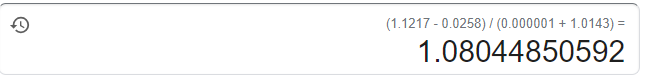

Works

In [9]:
class FeedForwardNetwork(nn.Module):
  def __init__(self, d_model: int, d_ff: int, dropout: float):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.dropout = nn.Dropout(dropout)
    self.linear2 = nn.Linear(d_ff, d_model)

    # FFN(x) = max(0, W1*x + b1) * W2 + b2
    # L1 -> relu -> L2    512 -> 2048 -> 512

  def forward(self, x):
      return self.linear2(self.dropout(torch.relu(self.linear1(x))))

In [10]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model: int, h: int, dropout: float):
    super().__init__()
    self.d_model = d_model
    self.h = h # No of attn heads
    assert d_model % h == 0, "d_model not divisible by h"

    self.d_k = d_model // h
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    # Here we are using linear layers for weight matrices w_q, w_k, w_v.
    # In Attention paper they are termed as weight matrices of (d_model, d_model) or (d_model, d_k)
    # But pytorch will help ease our work
    # output = XW + b -> this W is our required wt matrix and we can set the bias=False if not reqd
    # Q = self.w_q(x)
    # W_Q = self.w_q.weight

    self.w_o = nn.Linear(d_model, d_model)
    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(query, key, value, mask, dropout: nn.Dropout):
    d_k = query.shape[-1]

    attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
      attention_scores.masked_fill_(mask == 0, -1e9)
    if dropout is not None:
      attention_scores = dropout(attention_scores)

    return (attention_scores @ value), attention_scores


  def forward(self, q, k, v, mask):
    query = self.w_q(q) # (batch, seq_len, d_model) -> (batch, seq_len, d_model)
    key = self.w_k(k)
    value = self.w_v(v)

    # Our call for foward pass will have the same values for i/p params q, k, v = embeddings

    # Splitting into heads
    # (batch, seq_len, d_model) -> (batch, seq_len, h, d_k) -> (batch, h, seq_len, d_k)
    query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
    key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
    value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)


    x, self.attention_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)

    # (batch, h, seq_len, d_k) -> (batch, seq_len, h, d_k) -> (batch, seq_len, d_model)
    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

    return self.w_o(x)


mha = MultiHeadAttention(512, 8, 0.1)


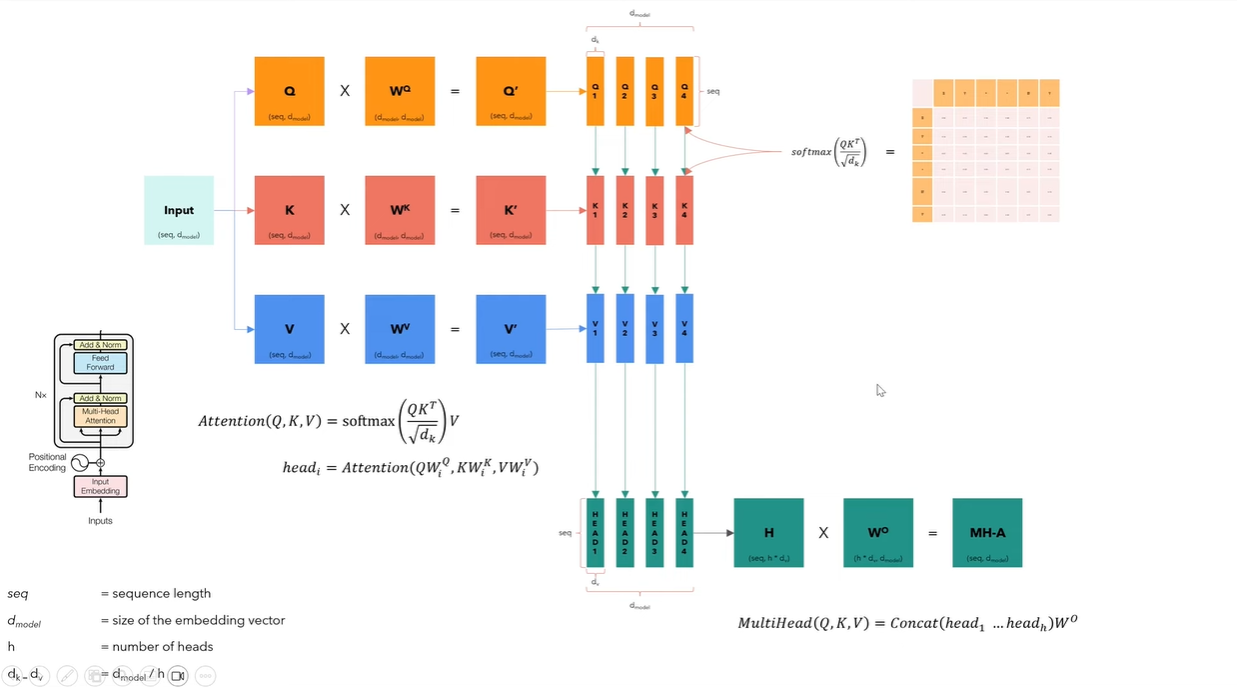

In [11]:
class ResidualConnection(nn.Module):
  def __init__(self, features:int, dropout: float):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNorm(features)

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

# Flow in an Encoder:


<img src="https://machinelearningmastery.com/wp-content/uploads/2021/10/transformer_1.png" width="400">

https://chatgpt.com/share/67488cd6-49d5-4032-8840-1d25f61d1c89

In [12]:
class EncoderBlock(nn.Module):
  def __init__(self, features: int,  self_attention_block: MultiHeadAttention, feed_forward_block: FeedForwardNetwork, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

  def forward(self, x, src_mask):
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
    x = self.residual_connections[1](x, self.feed_forward_block)
    return x

In [13]:
class Encoder(nn.Module):
  def __init__(self, features: int, layers: nn.ModuleList):
    super().__init__()
    self.layers = layers
    self.norm = LayerNorm(features)

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

In [14]:
class DecoderBlock(nn.Module):
  def __init__(self, features: int, self_attention_block: MultiHeadAttention, cross_attention_block: MultiHeadAttention, feed_forward_block: FeedForwardNetwork, dropout: float):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])


  def forward(self, x, encoder_output, src_mask, tgt_mask):
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x,x,x, tgt_mask))
    x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
    x = self.residual_connections[2](x, self.feed_forward_block)

    return x

In [15]:
class Decoder(nn.Module):
  def __init__(self, features: int,layers: nn.ModuleList):
    super().__init__()
    self.layers = layers
    self.norm = LayerNorm(features)

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, src_mask, tgt_mask)
    return self.norm(x)

In [16]:
class ProjectionLayer(nn.Module):
  def __init__(self, d_model: int, vocab_size: int):
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    return torch.log_softmax(self.proj(x), dim=-1)

In [17]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)

In [18]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:

  # Create embeddings
  src_embed = InputEmbeddings(d_model, src_vocab_size)
  tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

  # Create the positional enc
  src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
  tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

  # Encoder Blocks
  encoder_blocks = []
  for _ in range(N):
    encoder_self_attention_block = MultiHeadAttention(d_model, h, dropout)
    feed_forward_block = FeedForwardNetwork(d_model, d_ff, dropout)
    encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
    encoder_blocks.append(encoder_block)

  # Decoder block
  decoder_blocks=[]
  for _ in range(N):
        decoder_self_attention_block = MultiHeadAttention(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttention(d_model, h, dropout)
        feed_forward_block = FeedForwardNetwork(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

  # Create the encoder and decoder
  encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
  decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

  # Create the projection layer
  projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

  transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
  # Initialize the parameters
  for p in transformer.parameters():
      if p.dim() > 1:
          nn.init.xavier_uniform_(p)

  return transformer

# Datasets


In [19]:
!pip install --quiet datasets

In [20]:
def get_config():
    return {
        "batch_size": 16,
        "num_epochs": 15,
        "lr": 3e-5,
        "seq_len": 350,
        "d_model": 512,
        "datasource": 'opus_books',
        "lang_src": "en",
        "lang_tgt": "it",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel"
    }

cfg = get_config()
cfg['model_folder'] = '/pytorch-transformer/weights'
cfg['tokenizer_file'] = '/pytorch-transformer/vocab/tokenizer_{0}.json'
cfg['preload'] = None

In [21]:
def get_weights_file_path(config, epoch: str):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}{epoch}.pt"
    return str(Path('.') / model_folder / model_filename)

# Find the latest weights file in the weights folder
def latest_weights_file_path(config):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}*"
    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None
    weights_files.sort()
    return str(weights_files[-1])

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()
        self.seq_len = seq_len

        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Transform the text into tokens
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Add sos, eos and padding to each sentence
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # We will add <s> and </s>
        # We will only add <s>, and </s> only on the label
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        # Make sure the number of padding tokens is not negative. If it is, the sentence is too long
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        # Add <s> and </s> token
        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only <s> token
        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only </s> token
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Double check the size of the tensors to make sure they are all seq_len long
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,  # (seq_len)
            "decoder_input": decoder_input,  # (seq_len)
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(), # (1, 1, seq_len)
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)), # (1, seq_len) & (1, seq_len, seq_len),
            "label": label,  # (seq_len)
            "src_text": src_text,
            "tgt_text": tgt_text,
        }

def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

### Causal mask will return like this
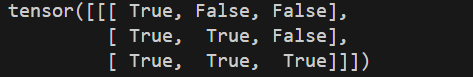

In [23]:
import os
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [24]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)


def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_step, writer, num_examples=2):
    model.eval()
    count = 0

    source_texts = []
    expected = []
    predicted = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            # Print the source, target and model output
            print_msg('-'*console_width)
            print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            if count == num_examples:
                print_msg('-'*console_width)
                break

def get_all_sentences(ds, lang):
    for item in ds:
        yield item['translation'][lang]

def get_or_build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    if not Path.exists(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer


In [25]:
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_step, writer, num_examples=2):
    model.eval()
    count = 0

    source_texts = []
    expected = []
    predicted = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            # Print the source, target and model output
            print_msg('-'*console_width)
            print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            if count == num_examples:
                print_msg('-'*console_width)
                break


In [26]:
!pip install --quiet tqdm
from torch.utils.tensorboard import SummaryWriter
import warnings
from tqdm import tqdm
from pathlib import Path
import warnings

In [27]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
def get_ds(config):
    # It only has the train split, so we divide it overselves
    ds_raw = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train')
    ds_raw = ds_raw.shuffle(seed=42).select(range(26000))
    # Build tokenizers
    tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Keep 90% for training, 10% for validation
    train_ds_size = int(0.9 * len(ds_raw))
    val_ds_size = len(ds_raw) - train_ds_size
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Find the maximum length of each sentence in the source and target sentence
    max_len_src = 0
    max_len_tgt = 0

    for item in ds_raw:
        src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')


    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt

def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config["seq_len"], config['seq_len'], d_model=config['d_model'])
    
    return model

def train_model(config):
    # Define the device
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    elif (device == 'mps'):
        print(f"Device name: <mps>")
    device = torch.device(device)

    # Make sure the weights folder exists
    Path(f"{config['datasource']}_{config['model_folder']}").mkdir(parents=True, exist_ok=True)

    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

    # If the user specified a model to preload before training, load it
    initial_epoch = 0
    global_step = 0
    preload = config['preload']
    model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None
#     if model_filename:
#         print(f'Preloading model {model_filename}')
#         state = torch.load(model_filename)
#         model.load_state_dict(state['model_state_dict'])
#         initial_epoch = state['epoch'] + 1
#         optimizer.load_state_dict(state['optimizer_state_dict'])
#         global_step = state['global_step']
#     else:
#         print('No model to preload, starting from scratch')
    state = torch.load("/kaggle/input/en-fr-model/pytorch/default/1/tmodel_07.pt")
    model.load_state_dict(state['model_state_dict'])
    initial_epoch = state['epoch'] + 1
    optimizer.load_state_dict(state['optimizer_state_dict'])
    global_step = state['global_step']
    

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:

            encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

            # Run the tensors through the encoder, decoder and the projection layer
            encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            # Compare the output with the label
            label = batch['label'].to(device) # (B, seq_len)

            # Compute the loss using a simple cross entropy
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            # Log the loss
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        # Run validation at the end of every epoch
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)


The dataset was cropped to 26k rows

Hyperparameters:
- "batch_size": 16,
- "num_epochs": 15,
- "lr": 3e-5,

In [28]:
if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    config = get_config()
    train_model(config)

Using device: cuda
Device name: Tesla T4
Device memory: 14.74127197265625 GB


Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

Max length of source sentence: 309
Max length of target sentence: 274
torch.Size([1, 350, 512])
torch.Size([1, 350, 512])


Processing Epoch 08: 100%|██████████| 1463/1463 [19:02<00:00,  1.28it/s, loss=6.115]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: You adhere to that resolution?"
    TARGET: Persistete nella vostra risoluzione?
 PREDICTED: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------
    SOURCE: She could not help smil

Processing Epoch 09: 100%|██████████| 1463/1463 [19:04<00:00,  1.28it/s, loss=6.234]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: The steward recommended the latter course, as it would come so much cheaper.
    TARGET: Il dispensiere gli raccomandò quest’ultimo modo, perchè avrebbe risparmiato molto.
 PREDICTED: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
-------------------------

Processing Epoch 10: 100%|██████████| 1463/1463 [19:06<00:00,  1.28it/s, loss=6.325]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: "She has screamed out on purpose," declared Abbot, in some disgust. "And what a scream!
    TARGET: — S'è messa a gridare senza ragione, — disse Abbot irritata. — Sarebbe scusabile se si fosse sentita male, ma lo ha fatto soltanto per farci accorrere.
 PREDICTED: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Processing Epoch 11: 100%|██████████| 1463/1463 [19:06<00:00,  1.28it/s, loss=6.567]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Here I meditated nothing but my escape, and what method I might take to effect it, but found no way that had the least probability in it; nothing presented to make the supposition of it rational; for I had nobody to communicate it to that would embark with me—no fellow-slave, no Englishman, Irishman, or Scotchman there but myself; so that for two years, though I often pleased myself with the imagination, yet I never had the least encouraging prospect of putting it in practice.
    TARGET: Quivi non meditava ad altro che alla mia fuga, e al modo di mandarla ad effetto; ma non trovava un espediente che avesse nemmeno la probabilità di riuscita. Nulla si presentava che mostrasse almen ragionevole questa mia idea; non un solo al quale potessi comunicarla per indurlo ad imbarcarsi con me; non un compagno di schiavitù, non un Inglese, non un Irlandese, non uno Scozzese; per due anni dunque, se bene m

Processing Epoch 12: 100%|██████████| 1463/1463 [19:06<00:00,  1.28it/s, loss=6.035]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    SOURCE: Dolly!' she said suddenly, changing her tone, 'you say I look at things too dismally; you cannot understand.
    TARGET: Dolly! — ella cambiò discorso a un tratto — tu dici che io guardo cupamente. Tu non puoi capire.
 PREDICTED: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Processing Epoch 13:  24%|██▍       | 350/1463 [04:34<14:34,  1.27it/s, loss=6.153]


KeyboardInterrupt: 